In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs

2023-06-15 11:20:01.430918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 11:20:07.919836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv", index_col=0)
molecule_features_dummy = pd.read_csv("./data/mol_dummy_rdkit.csv", index_col=0)
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)

In [3]:
graph = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(graph.info())
graph.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 23319, Edges: 40000

 Node types:
  molecule: [12871]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [10448]
    Features: float32 vector, length 5048
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [20000]
        Weights: all 1 (default)
        Features: none


In [4]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

In [5]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.2, method="global", edge_label="present_in", keep_connected=False
)

print(graph_test.info())

Network has 20000 edges of type present_in
Network has 20000 edges of type present_in
** Sampled 4000 positive and 4000 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 23319, Edges: 36000

 Node types:
  molecule: [12871]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [10448]
    Features: float32 vector, length 5048
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [16000]
        Weights: all 1 (default)
        Features: none


In [6]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.2, method="global", edge_label="present_in", keep_connected=False
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

Network has 16000 edges of type present_in
Network has 16000 edges of type present_in
** Sampled 3200 positive and 3200 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 23319, Edges: 32800

 Node types:
  molecule: [12871]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [10448]
    Features: float32 vector, length 5048
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [12800]
        Weights: all 1 (default)
        Features: none


In [7]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,4800,Train Graph,Test Graph,Train the Link Classifier
Model Selection,1600,Train Graph,Test Graph,Select the best Link Classifier model
Test set,8000,Test Graph,Full Graph,Evaluate the best Link Classifier


In [11]:
dimensions = 128
num_walks = 1 #default : 1
walk_length = 100
context_window_size = 10
num_iter = 5 #default : 10
workers = multiprocessing.cpu_count() - 2
user_metapaths = [
    ["species", "molecule", "species"],
    ["molecule", "species", "molecule"]
]

In [12]:
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec


def metapath2vec_embedding(graph, name):
    rw = UniformRandomMetaPathWalk(graph)
    walks = rw.run(
        graph.nodes(), n=num_walks, length=walk_length, metapaths=user_metapaths
    )
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [13]:
embedding_train = metapath2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 23319


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(link_examples,
                                link_labels,
                                get_embedding,
                                binary_operator):

    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [15]:
def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_l1, operator_l2]

In [16]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l1'


,ROC AUC score
name,
operator_l1,0.960810
operator_l2,0.958178


In [17]:
embedding_test = metapath2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 23319


In [18]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l1': 0.9436777187499998


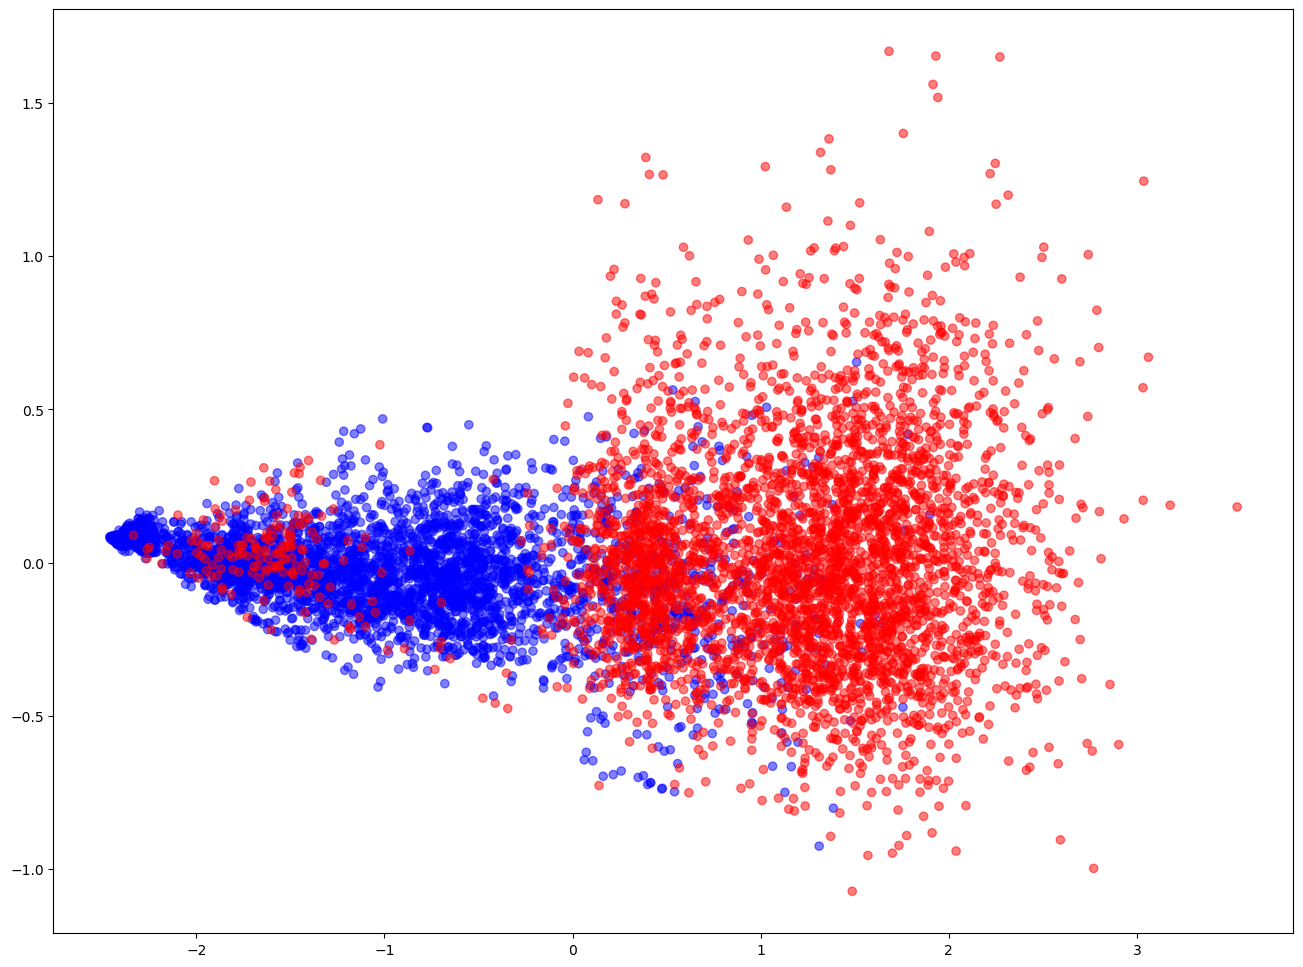

In [19]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

In [20]:
examples_train

array([['COC(=O)CC1C(C)(C)C(OC(=O)C(C)C)C2(O)CC3=C4CC(=O)OC(c5ccoc5)C4(C)CCC3C1(C)C2=O',
        'Swietenia mahagoni'],
       ['COC1C(OC2C(OCCC(CCC(C)C3CC(O)C4C3(C)CCC3C5(C)CCC(O)C(O)C5C(O)CC34O)C(C)C)OCC(O)C2O)OCC(O)C1O',
        'Eurybia conspicua'],
       ['CC1=CCCC2C1(C=O)CCC(C)C2(C)CCc1ccoc1', 'Croton cortesianus'],
       ...,
       ['CC=C(C)C(=O)OC1CCC(C)C2(C)C(O)c3c(C)coc3CC12',
        'Ligularia lamarum'],
       ['CC(C)=CCCC(C)c1ccc(C)cc1', 'Bidens andicola'],
       ['CCC(C=CC(C)C1CCC2C3C(=O)C=C4CC(O)CCC4(C)C3CCC12C)C(C)C',
        'Oryza sativa']], dtype=object)

In [21]:
best_result["classifier"].predict_proba(link_features)[-2]

array([0.84036165, 0.15963835])

In [25]:
ex_test = np.array([['COC(=O)CC1C(C)(C)C(OC(=O)C(C)C)C2(O)CC3=C4CC(=O)OC(c5ccoc5)C4(C)CCC3C1(C)C2=O', 'Mus musculus']])

In [26]:
link = link_examples_to_features(ex_test, embedding_test, best_result['binary_operator'])

In [27]:
best_result['classifier'].predict_proba(link)

array([[0.57598395, 0.42401605]])